<a href="https://colab.research.google.com/github/PizzaGitHub/LeNet_5_study/blob/main/MNIST_masking_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries, check cuda and mount google drive

In [ ]:
import torch
import torch.nn as nn
from torch import flatten
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torch.optim import lr_scheduler
from torch.nn import CrossEntropyLoss

if torch.cuda.is_available():
  print(f"CUDA device: {torch.cuda.get_device_name(0)} \n")
  device = 'cuda'
else:
  print(f"CUDA not available.")
  device = 'cpu'

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import tqdm
from torchvision import datasets, transforms
from torchsummary import summary

from google.colab import drive

drive.mount('./drive')

!ls drive/MyDrive/Code/ -l
PATH = 'drive/MyDrive/Code/MNIST-masking-experiment'

CUDA device: Tesla T4 

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).
total 16
drwx------ 2 root root 4096 May 20 19:29 COVID19-Grafici-Regionali
drwx------ 2 root root 4096 May 20 19:31 Miscellaneous
drwx------ 5 root root 4096 May 20 19:24 MNIST-masking-experiment
drwx------ 2 root root 4096 May 20 19:26 NLP-Kaggle-tries


# Dataset

### CLASS : transform `maskMNIST()`

In [ ]:
# we have to call the transform passing two tuple argumsnts:
# - g_tuple = [g_min,g_max]
# - w_tuple = [w_min, w_max]

class maskMNIST(object):

  def __init__(self, g_tuple=[10,15],w_tuple=[2,4]):
    self.gridParams = [g_tuple,w_tuple]


  def __call__(self,sample):

    resolution = sample.shape[1]
    sample = sample.detach().clone()

    # define the stripe values
    np.random.seed()
    stripeGauge = np.random.randint(self.gridParams[0][0],self.gridParams[0][1],2)
    stripeWidth = np.random.randint(self.gridParams[1][0],self.gridParams[1][1],2)
    stripeGap_x = np.random.randint(0,stripeGauge[0])
    stripeGap_y = np.random.randint(0,stripeGauge[1])

    #draw the grid from the params
    for i in range(stripeWidth[0]):
      sample[0,stripeGap_x+i:resolution:stripeGauge[0],:] = 0
      #sample[i:stripeGauge[0]+i*stripeWidth[0],:] = 0.5
      
    for i in range(stripeWidth[1]):
      sample[0,:,stripeGap_y+i:resolution:stripeGauge[1]] = 0
      #sample[:,i:stripeGauge[1]+i*stripeWidth[1]] = 0.5
    
    return sample
  



## CLASS : transform `invert_colors()`

In [ ]:
class invert_colors(object):
  def __init__(self):

  def __call__(self, sample):
    self 
    sample = -sample
    return


### AUX: load_masked_testset

In [ ]:
def load_masked_testset(gauge,width,for_lenet=False):
  mask_trasf = maskMNIST(gauge,width)
  
  # define the masking transforms
  combo = transforms.Compose([
                              transforms.ToTensor(),
                              mask_trasf
  ])

  combo_for_lenet = transforms.Compose([
                                        transforms.Pad(2),
                                        transforms.ToTensor(),
                                        mask_trasf
  ])
  
  if for_lenet:
    payload = datasets.MNIST(PATH, train=False, download=True, transform=combo_for_lenet)
  else:
    payload = datasets.MNIST(PATH, train=False, download=True, transform=combo)

  return payload

### AUX: masked_test_accuracy

In [ ]:
def masked_test_accuracy(model, gauge, width, for_lenet=False, plotting=False):
  # load the testset
  testset = load_masked_testset(gauge,width,for_lenet=for_lenet)

  # show an some example test items
  if plotting:
    indexes = np.random.randint(0,testset.__len__(), 5)
    fig = plt.figure(figsize=(20,10))
    for i in range(5):
      fig.add_subplot(1,5,i+1)
      plt.imshow(testset[indexes[i]][0].reshape(32,32),cmap='gray')

  model.eval()
  accuracy_loader = DataLoader(testset, batch_size=10000)
  for batch, labels in accuracy_loader:
    batch = batch.to(device)
    out = model(batch)
    
  scores = (testset.targets == out.argmax(axis=1).cpu()).sum()
  payload = scores/testset.__len__()
  
  return payload

## CALL : All the transforms

In [ ]:
vanilla = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize
])

for_lenet = transforms.Compose([
    vanilla,
    transforms.Pad(2)
])

inverted_vanilla = transforms.Compose([
    vanilla,
         
])


### Load MNIST trainset



tensor(0.5000)


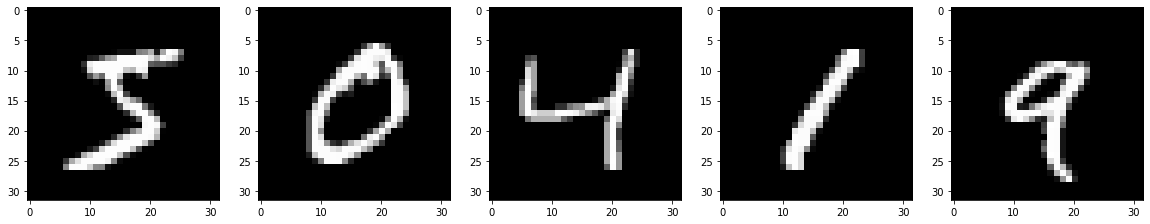

In [ ]:
trainset = datasets.MNIST(PATH, download=True, train=True,transform=for_lenet)

fig = plt.figure(figsize=[20,10])
for i in range(5):
  fig.add_subplot(1,5,i+1)
  plt.imshow(trainset.__getitem__(i)[0].reshape([32,32]), cmap='gray')

print(trainset.__getitem__(2)[0].max())

# Custom nets

### `Squafra_lenet`

In [ ]:
class Squafra_lenet(nn.Module):
    def __init__(self):
        super().__init__()
        
                                                                           #input 1x28x28
        self.conv1 = nn.Conv2d(1,8,kernel_size = 5 , stride = 1, padding = 0)      #8x24x24
        self.batch1 = nn.BatchNorm2d(8, track_running_stats=False)
        self.drop1 = nn.Dropout(0.1)

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)                          #8x8x8
 
        self.conv2 = nn.Conv2d(8,16, kernel_size = 5 , stride = 1 , padding = 0)        #4x4x16
        self.batch2 = nn.BatchNorm2d(16, track_running_stats=False)
        self.drop2 = nn.Dropout(0.1)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2 )                     #16x2x2

        self.linear1 = nn.Linear(64, 200) 
        self.linear2 = nn.Linear(200,10)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.drop1(out)
        out = self.relu(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.batch2(out)
        out = self.drop2(out)
        out = self.relu(out)
        out = self.pool2(out)

        out = flatten(out,1)

        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        
        return out

### `Lenet_5`
CAVEAT: this class needs the `device` argument passed upon istantiation if you want to run it on GPU.

In [ ]:
class Lenet_5(nn.Module):

  def __init__(self,device='cpu'):
    super().__init__()

    self.device = device
    self.tanh = nn.Tanh()
    self.conv1 = nn.Conv2d(1,6,kernel_size=5, stride=1)
    self.subsample1 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv2_in_3 = nn.Conv2d(3,1,kernel_size=5,stride=1)
    self.conv2_in_4 = nn.Conv2d(4,1,kernel_size=5,stride=1)
    self.conv2_in_6 = nn.Conv2d(6,1,kernel_size=5,stride=1)
    self.sub_sample2 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(16,120,kernel_size=5,stride=1)

    self.linear1 = nn.Linear(120,84)
    self.linear2 = nn.Linear(84,10)

    self.tanh = nn.Tanh()
  
  def forward(self,x):
    dim = x.shape[0]
    out = self.conv1(x)
    out = self.tanh(out)
    out = self.subsample1(out)

    basket = torch.zeros((dim,16,10,10)).to(device)
    
    basket[:,0,:,:] = self.conv2_in_3(out[:,[0,1,2],:,:])[:,0,:,:]
    basket[:,1,:,:] = self.conv2_in_3(out[:,[1,2,3],:,:])[:,0,:,:]
    basket[:,2,:,:] = self.conv2_in_3(out[:,[2,3,4],:,:])[:,0,:,:]
    basket[:,3,:,:] = self.conv2_in_3(out[:,[3,4,5],:,:])[:,0,:,:]
    basket[:,4,:,:] = self.conv2_in_3(out[:,[0,4,5],:,:])[:,0,:,:]
    basket[:,5,:,:] = self.conv2_in_3(out[:,[0,1,5],:,:])[:,0,:,:]
    basket[:,6,:,:] = self.conv2_in_4(out[:,[0,1,2,3],:,:])[:,0,:,:]
    basket[:,7,:,:] = self.conv2_in_4(out[:,[1,2,3,4],:,:])[:,0,:,:]
    basket[:,8,:,:] = self.conv2_in_4(out[:,[2,3,4,5],:,:])[:,0,:,:]
    basket[:,9,:,:] = self.conv2_in_4(out[:,[0,3,4,5],:,:])[:,0,:,:]
    basket[:,10,:,:] = self.conv2_in_4(out[:,[0,1,4,5],:,:])[:,0,:,:]
    basket[:,11,:,:] = self.conv2_in_4(out[:,[0,1,2,5],:,:])[:,0,:,:]
    basket[:,12,:,:] = self.conv2_in_4(out[:,[0,1,3,4],:,:])[:,0,:,:]
    basket[:,13,:,:] = self.conv2_in_4(out[:,[1,2,4,5],:,:])[:,0,:,:]
    basket[:,14,:,:] = self.conv2_in_4(out[:,[0,2,3,5],:,:])[:,0,:,:]
    basket[:,15,:,:] = self.conv2_in_6(out)[:,0,:,:]
    
    out = basket
    out = self.tanh(out)
    out = self.sub_sample2(out)
    out = self.conv3(out)

    temp = torch.zeros(dim,120).to(device)

    for idx in range(dim):
      temp[idx,:] = out[idx,:,0,0]
    
    out = temp
    out = self.tanh(out)
    out = self.linear1(out)
    out = self.tanh(out)
    out = self.linear2(out)

    return out

### Choose the model

In [ ]:
model_name = 'Lenet_5'
model = Lenet_5(device).to(device)
#summary(model,(1,28,28))

# Training

### Training parameters
Train parameters: Lenet-5 
  - Lenet-5: SGD(minibatches size 16, LR 10-2, nesterov 0.9)
  - Squafra (

In [ ]:
loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
optimizer = Adam(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose = True)

### Train or load
Train the model or load a pretrained one

In [ ]:
retrain = False
epochs = 10

if retrain:
  for i in range(epochs):
    for batch, labels in loader:
      batch, labels = batch.to(device), labels.to(device)
      batch = batch.float()

      model.train()
      optimizer.zero_grad()

      out = model(batch)

      loss = loss_fn(out, labels)

      loss.backward()
      optimizer.step()
    
    scheduler.step(loss)
    
    if (((i+1)*100)%epochs == 0):
      print(f'training {i+1}0%: loss = {loss.item()}')
  
  torch.save(model,f"{PATH}/trained_models/trained_{model_name}.pt")
  
else:
  model = torch.load(f"{PATH}/trained_models/trained_{model_name}.pt")
  print(model.state_dict)

<bound method Module.state_dict of Lenet_5(
  (tanh): Tanh()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (subsample1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2_in_3): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_in_4): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_in_6): Conv2d(6, 1, kernel_size=(5, 5), stride=(1, 1))
  (sub_sample2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)>


### Show some filters

torch.Size([6, 1, 5, 5])


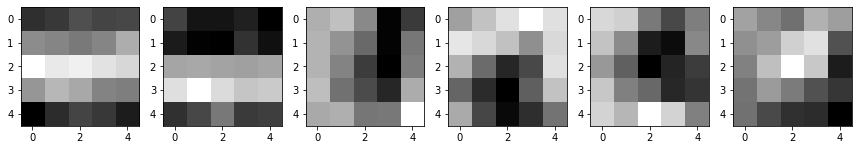

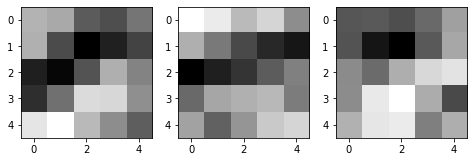

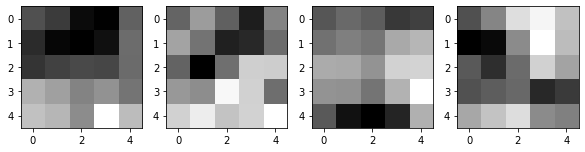

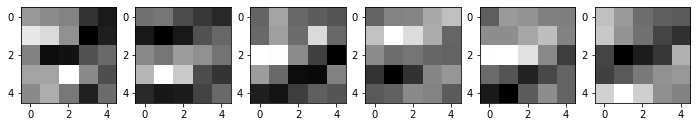

In [ ]:
kernels1 = model.cpu().conv1.weight.detach().clone()
print(kernels1.shape)
fig = plt.figure(figsize=(20,10))
for i in range(6):
  fig.add_subplot(1,8,i+1)
  plt.imshow(kernels1[i,0,:,:],cmap='gray')


kernels2_in_3 = model.conv2_in_3.weight.detach().clone()
kernels2_in_4 = model.conv2_in_4.weight.detach().clone()
kernels2_in_6 = model.conv2_in_6.weight.detach().clone()

fig = plt.figure(figsize=(8,5))
for i in range(3):
  fig.add_subplot(1,3,i+1)
  plt.imshow(kernels2_in_3[0,i,:,:],cmap='gray')

fig = plt.figure(figsize=(10,5))
for i in range(4):
  fig.add_subplot(1,4,i+1)
  plt.imshow(kernels2_in_4[0,i,:,:],cmap='gray')

fig = plt.figure(figsize=(12,5))
for i in range(6):
  fig.add_subplot(1,6,i+1)
  plt.imshow(kernels2_in_6[0,i,:,:],cmap='gray')


plt.show()


# Accuracies


### Training accuracy

In [ ]:
model.eval()
if torch.cuda.is_available():
  model = model.cuda()
accuracy_loader = DataLoader(trainset, batch_size=60000)
for batch, labels in accuracy_loader:
  if torch.cuda.is_available():
    batch = batch.cuda()
  out = model(batch)

scores = (trainset.targets == out.argmax(axis=1).cpu()).sum()
print(f"Training accuracy: {scores/trainset.__len__()}")

Training accuracy: 0.9973000288009644


### Test accuracy


Test accuracy: 0.944599986076355


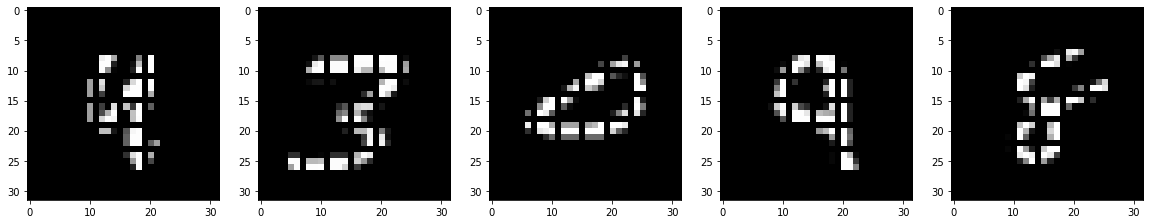

In [ ]:
gauge = [4,5]
width = [1,2]
plotting = True
for_lenet = True

test_accuracy = masked_test_accuracy(model,gauge,width,plotting,for_lenet)
print(f"Test accuracy: {test_accuracy.item()}")

### Accuracy vs masking width/gauge
Plot of test accuracy values against variation of mask width and gauge

Accuracy vs width, fixed gauge 10

In [ ]:
width_scores = []
temp_scores = []

# ricostruiamo lo stesso esperimento per fare una sorta di statistica (sembra
# che non serva)
tries = 1

for k in range(tries):
  for i in range(1,7):
    accuracy = masked_test_accuracy(
        model,
        [10,11],
        [i,i+1],
        for_lenet = True,
        plotting = False)
    
    temp_scores.append(accuracy)

  width_scores.append(temp_scores)
  temp_scores = []

  print(f'Ended try {k+1}')
  
width_scores_tens = torch.tensor(width_scores)
mean_width_scores = width_scores_tens.mean(axis=0)
width_scores_errs = width_scores_tens.std(axis=0)

Ended try 1


Accuracy vs gauge, fixed width 1

In [ ]:
temp_scores = []
gauge_scores = []

tries=1

for k in range(tries):
  for i in range(2,10):
    accuracy = masked_test_accuracy(
        model,
        [i,i+1],
        [1,2],
        for_lenet = True,
        plotting = False)
    
    temp_scores.append(accuracy)

  gauge_scores.append(temp_scores)
  temp_scores = []

  print(f"Ended try {k+1}")

gauge_scores_tens = torch.tensor(gauge_scores)
mean_gauge_scores = gauge_scores_tens.mean(axis=0)
gauge_scores_errs = gauge_scores_tens.std(axis=0)

Ended try 1


Plot the graphs

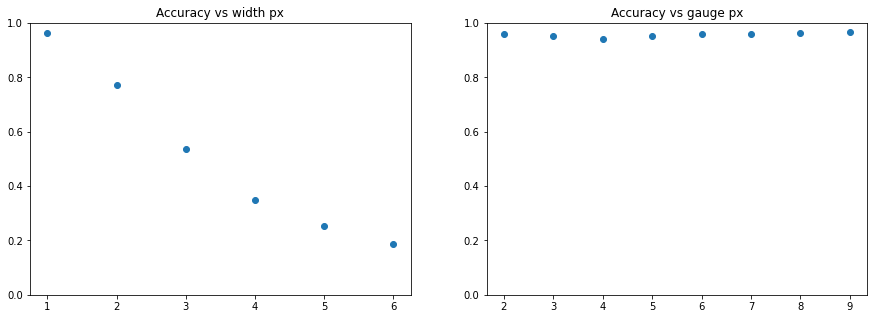

In [ ]:
fig = plt.figure(figsize=(15,5))

fig1 = fig.add_subplot(1,2,1)
fig1.title.set_text('Accuracy vs width px')
fig1.set_ylim([0,1])
plt.errorbar(range(1,7),mean_width_scores,yerr=width_scores_errs, fmt='o')


fig2 = fig.add_subplot(1,2,2)
fig2.title.set_text('Accuracy vs gauge px')
fig2.set_ylim([0,1])
plt.errorbar(range(2,10),mean_gauge_scores,yerr=gauge_scores_errs, fmt='o')

plt.show()


# Test vs custom digits

In [ ]:
from PIL import Image
import torch.nn.functional as F

def test_custom_digit(digit):
  PATH = f"drive/MyDrive/Code/MNIST-masking-experiment/cifre/pennello_1/bianco_{digit}.png"
  with Image.open(PATH) as img:
    array = np.array(img)

  plt.imshow(array)
  plt.show() 

  tens = torch.from_numpy(array[:,:,0])
  tens = F.pad(input=tens, pad=(2,2,2,2),value=0)
  tens = tens.reshape(1,32,32)/255
  tens = tens.unsqueeze(1).cuda()

  out = model(tens)
  prediction = out.argmax(axis=1)

  print(f"Input: {digit}, prediction {prediction.item()}")
  
  return prediction.item()
  

accuracy = 0

for i in range(0,10):
  guess = test_custom_digit(i)
  if (i==guess):
    accuracy += 1

print(f"Accuracy: {accuracy/10}")

# Single layers study

In [ ]:
class network_c1(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,6,kernel_size=5, stride=1, padding=2)
    self.tanh = nn.Tanh()

  def forward(self,img):
    out = self.conv1(img)
    out = self.tanh(out)

    return out

<bound method Module.state_dict of network_c1(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (tanh): Tanh()
)>


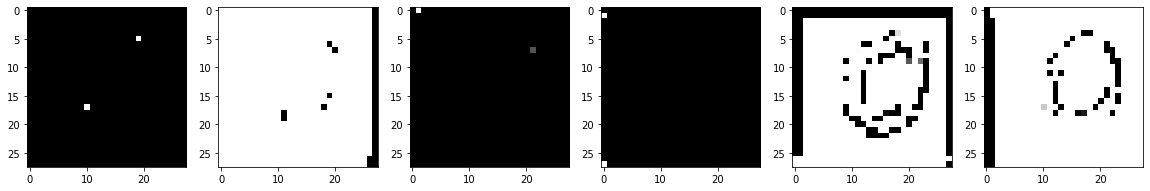

In [ ]:
model_c1 = network_c1()
model_c2 = network_c1()
print(model_c1.state_dict)

PATH = f"drive/MyDrive/Code/MNIST-masking-experiment/cifre/sottili_1/bianco_0.png"
with Image.open(PATH) as img:
 array = np.array(img)

tens = torch.from_numpy(array[:,:,0])
tens = torch.unsqueeze(tens, 0)
tens = torch.unsqueeze(tens, 0).float()

out = model_c1(tens)
out=out.detach().numpy()

fig = plt.figure(figsize=(20,5))

for i in range(6):
  fig.add_subplot(1,6,i+1)
  plt.imshow(out[0,i,:,:], cmap='gray')

plt.show()
